# Set up environment and load in data

In [1]:
library(tidyverse)
library(here)
theme_set(theme_bw())
helpers_path = paste0(here(),'/analysis/helpers/')
fig_out_path = paste0(here(), '/outputs/fig/')

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
here() starts at /Users/zenkavi/Documents/RangelLab/NovelVsRepeated/behavior



In [2]:
data_bc_fix = read.csv(paste0(here(), '/inputs/data_fixBC.csv'))

data_bc_fix = data_bc_fix %>%
  mutate(correct = ifelse(possiblePayoffleft>possiblePayoffright & leftChosen == 1, 1, ifelse(possiblePayoffleft<possiblePayoffright & leftChosen == 0, 1, 0))) %>%
  mutate(type = ifelse(typeLeft == 1, "HT", "RE")) %>%
  mutate(val_diff = possiblePayoffleft - possiblePayoffright,
         val_diff_bin = round(val_diff/50),
         val_diff_bin_str = paste0(val_diff_bin*50-25,":",val_diff_bin*50+25),
         val_diff_bin_str = factor(val_diff_bin_str, levels = c("-275:-225","-225:-175", "-175:-125", "-125:-75", "-75:-25", "-25:25", "25:75", "75:125", "125:175", "175:225", "225:275")),
         abs_val_diff_bin_str =  paste0(abs(val_diff_bin)*50-25,":",abs(val_diff_bin)*50+25),
         abs_val_diff_bin_str = ifelse(abs_val_diff_bin_str ==  "-25:25", "0:25", abs_val_diff_bin_str),
         abs_val_diff_bin_str = factor(abs_val_diff_bin_str, levels = c("0:25", "25:75", "75:125", "125:175", "175:225", "225:275"))) %>%
  filter(!is.na(val_diff_bin_str))

# Effects of training on fixation patterns

## Number of fixations

In [ ]:
p = data_bc_fix %>%
  filter(lastFix == 0) %>%
  group_by(subnum, day, type, val_diff_bin_str) %>%
  summarise(mean_num_fix = mean(numTotalFix), .groups="keep") %>%
  ungroup() %>%
  group_by(day, type, val_diff_bin_str) %>%
  summarise(.groups = 'keep',
            sem_num_fix = sd(mean_num_fix)/sqrt(n()),
            mean_num_fix = mean(mean_num_fix),
            num_trials = n()) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")))%>%
  ggplot(aes(val_diff_bin_str, mean_num_fix, color = type))+
  geom_vline(aes(xintercept = 6), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_num_fix - sem_num_fix, ymax = mean_num_fix + sem_num_fix), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Left - Value Right", y = "Mean Number of Fixations", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_y_continuous(breaks = seq(0,10,2))+
  scale_x_discrete(labels=c("","-225:-175", "", "-125:-75", "", "-25:25", "", "75:125", "", "175:225", ""))

# ggsave(file=paste0(fig_out_path, 'bc_group_meanNumFixOverValDiff.jpg'), p, height = 5, width = 8, units="in")
p

## Total side fixation duration on value difference

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


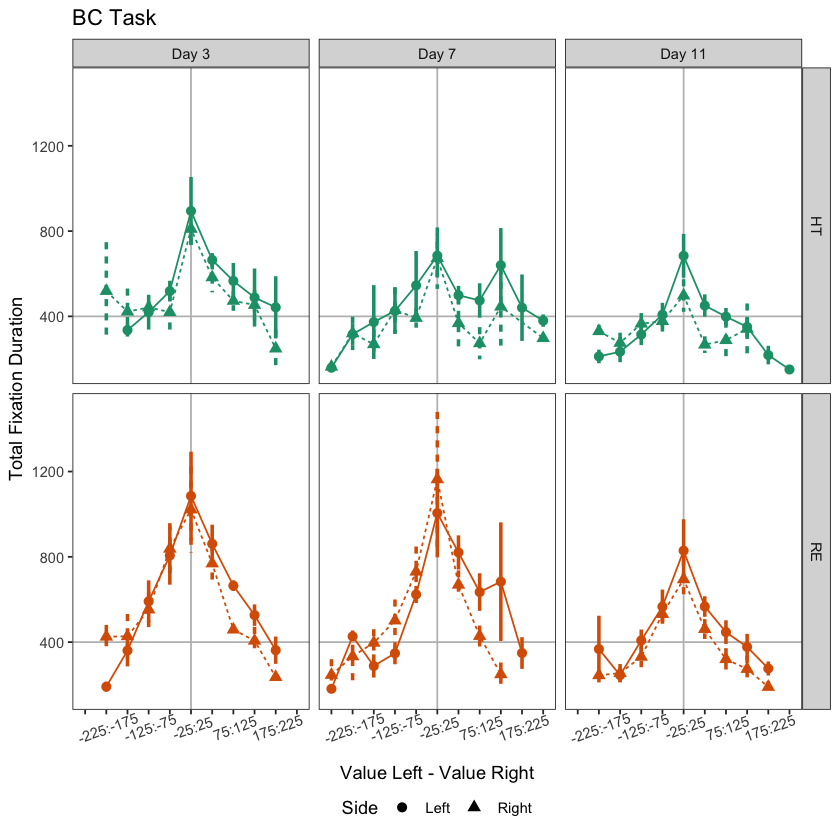

In [3]:
p = data_bc_fix %>%
  group_by(subnum, day, type, trialNum, leftFix) %>%
  summarise(.groups = "keep",
            totalFixDuration = sum(fixDuration),
            val_diff_bin_str = unique(val_diff_bin_str)) %>%
  mutate(leftFix = ifelse(leftFix == 1, "Left", "Right")) %>%
  ungroup() %>%
  group_by(subnum, day, type, val_diff_bin_str, leftFix) %>%
  summarise(mean_dur = mean(totalFixDuration), .groups = 'keep') %>%
  ungroup() %>%
  group_by(day, type, val_diff_bin_str, leftFix) %>% 
  summarise(.groups = 'keep',
            sem_dur = sd(mean_dur)/sqrt(n()),
            mean_dur = mean(mean_dur),
            num_trials = n()) %>%
  filter(num_trials > 1) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(val_diff_bin_str, mean_dur, color = type, shape=leftFix, linetype=leftFix))+
  geom_vline(aes(xintercept=6), color="gray")+
  geom_hline(aes(yintercept=400), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_dur - sem_dur, ymax = mean_dur + sem_dur), width = 0, size = 1)+
  geom_line(aes(group = leftFix))+
  labs(title = "BC Task", y = "Total Fixation Duration", x = "Value Left - Value Right", color="", shape = "Side")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 20, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_x_discrete(labels=c("","-225:-175", "", "-125:-75", "", "-25:25", "", "75:125", "", "175:225", ""))+
  ylim(150,1500)+
  scale_linetype(guide = "none")

# ggsave(file=paste0(fig_out_path, 'bc_group_FixDurOverValDiffByStim.jpg'), p, height = 5, width=8, units="in")
p

## Relative fixation duration

y: relative fixation time
x: relative value difference
color: HT vs RE

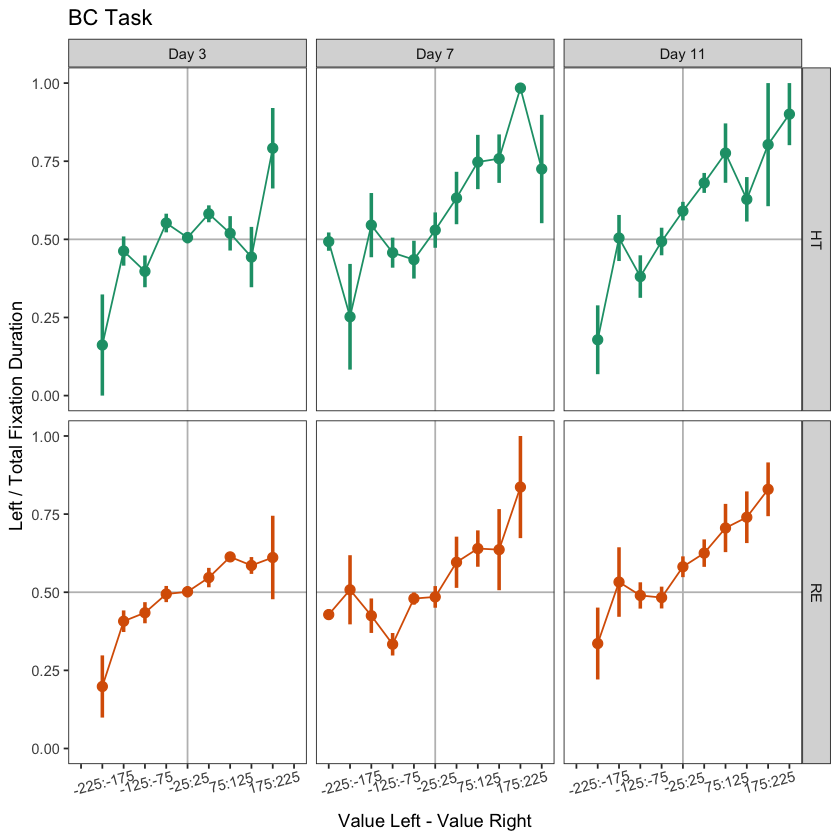

In [4]:
p = data_bc_fix %>%
  group_by(subnum, day, type, trialNum, leftFix, val_diff_bin_str) %>%
  summarise(.groups = "keep",
            totalFixDuration = sum(fixDuration)) %>%
  mutate(leftFix = ifelse(leftFix == 1, "LeftDur", "RightDur")) %>%
  spread(leftFix, totalFixDuration) %>%
  mutate(LeftDur = ifelse(is.na(LeftDur), 0, LeftDur),
         RightDur = ifelse(is.na(RightDur), 0, RightDur),
         propLeftFixDur = LeftDur/ (RightDur+LeftDur)) %>%
  ungroup() %>%
  group_by(subnum, day, type, val_diff_bin_str) %>%
  summarise(.groups = "keep",
            mean_propLeftFixDur = mean(propLeftFixDur)) %>%
  ungroup() %>%
  group_by(day, type, val_diff_bin_str) %>%
  summarise(.groups = 'keep',
            sem_propLeftFixDur = sd(mean_propLeftFixDur)/sqrt(n()),
            mean_propLeftFixDur = mean(mean_propLeftFixDur),
            num_trials = n()) %>%
  filter(num_trials > 1) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")))%>%
  ggplot(aes(val_diff_bin_str, mean_propLeftFixDur, color = type))+
  geom_hline(aes(yintercept = .5), color="gray")+
  geom_vline(aes(xintercept = 6), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_propLeftFixDur - sem_propLeftFixDur, ymax = mean_propLeftFixDur + sem_propLeftFixDur), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Left - Value Right", y = "Left / Total Fixation Duration", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_x_discrete(labels=c("","-225:-175", "", "-125:-75", "", "-25:25", "", "75:125", "", "175:225", ""))+
  scale_y_continuous(breaks = seq(0,1,.25))

# ggsave(file=paste0(fig_out_path, 'bc_group_propLeftFixDurOverValDiff.jpg'), p, height = 5, width = 8, units="in")
p

## p(First Fix == Left)

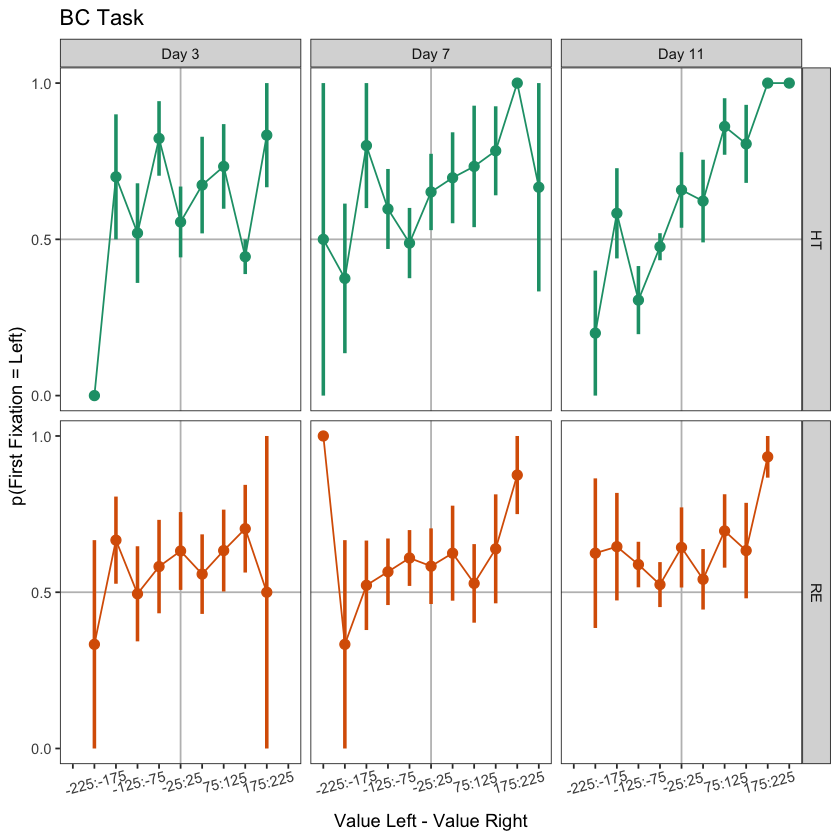

In [5]:
p = data_bc_fix %>%
  filter(firstFix == 1) %>%
  group_by(subnum, day, type, val_diff_bin_str) %>%
  summarise(mean_first_fix_left = mean(leftFix),
            num_trials = n(), .groups="keep") %>%
  ungroup() %>%
  group_by(day, type, val_diff_bin_str) %>%
  summarise(.groups = 'keep',
            sem_first_fix_left = sd(mean_first_fix_left)/sqrt(n()),
            mean_first_fix_left = mean(mean_first_fix_left),
            num_trials = n()) %>%
  filter(num_trials>1) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(val_diff_bin_str, mean_first_fix_left, color = type))+
   geom_hline(aes(yintercept=.5), color="gray")+
  geom_vline(aes(xintercept=6), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_first_fix_left - sem_first_fix_left, ymax = mean_first_fix_left + sem_first_fix_left), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Left - Value Right", y = "p(First Fixation = Left)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_x_discrete(labels=c("","-225:-175", "", "-125:-75", "", "-25:25", "", "75:125", "", "175:225", ""))+
  scale_y_continuous(breaks = seq(0,1,.5))

# ggsave(file=paste0(fig_out_path, 'bc_group_pFirstFixLeftOverValDiff.jpg'), p, height = 5, width=8, units="in")
p

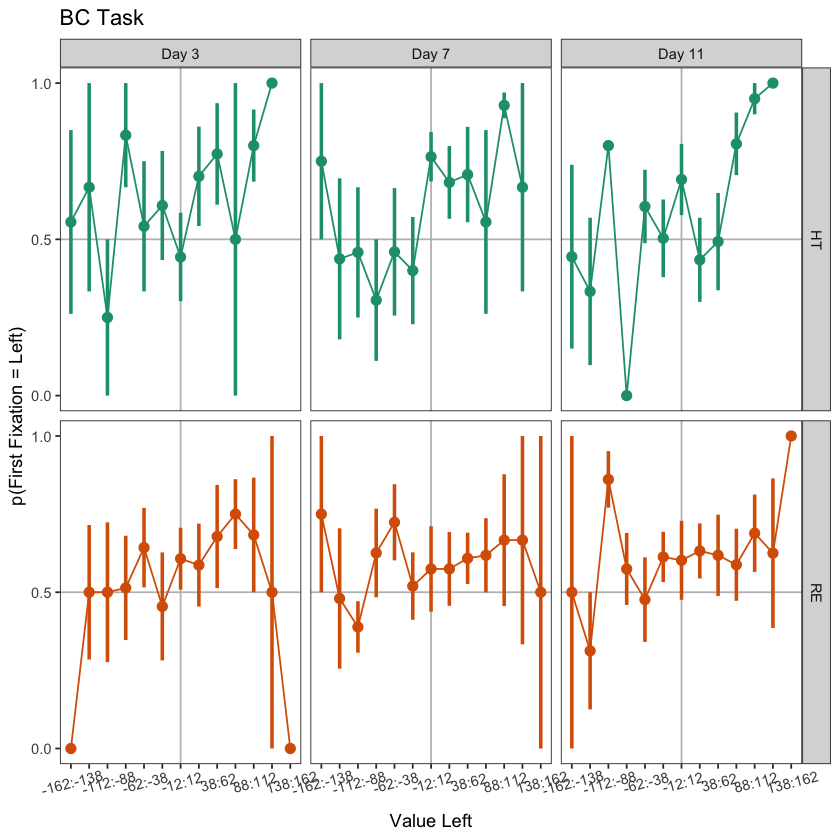

In [6]:
p = data_bc_fix %>%
  filter(firstFix == 1) %>%
  mutate(left_val_bin = round(possiblePayoffleft/25),
         left_val_bin_str = paste0( left_val_bin*25-12, ":" , left_val_bin*25+12),
         left_val_bin_str = factor(left_val_bin_str, levels = c("-162:-138", "-137:-113", "-112:-88", "-87:-63", "-62:-38", "-37:-13", "-12:12", "13:37", "38:62", "63:87", "88:112", "113:137", "138:162"))) %>%
  group_by(subnum, day, type, left_val_bin_str) %>%
  summarise(mean_first_fix_left = mean(leftFix),
            num_trials = n(), .groups="keep") %>%
  ungroup() %>%
  group_by(day, type, left_val_bin_str) %>%
  summarise(.groups = 'keep',
            sem_first_fix_left = sd(mean_first_fix_left)/sqrt(n()),
            mean_first_fix_left = mean(mean_first_fix_left),
            num_trials = n()) %>%
  # filter(num_trials>2) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(left_val_bin_str, mean_first_fix_left, color = type))+
   geom_hline(aes(yintercept=.5), color="gray")+
  geom_vline(aes(xintercept = 7), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_first_fix_left - sem_first_fix_left, ymax = mean_first_fix_left + sem_first_fix_left), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Left", y = "p(First Fixation = Left)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_discrete(labels=c("-162:-138", "", "-112:-88", "", "-62:-38", "", "-12:12", "", "38:62", "", "88:112", "", "138:162"))

# ggsave(file=paste0(fig_out_path, 'bc_group_pFirstFixLeftOverLeftVal.jpg'), p, height = 5, width=8, units="in")
p

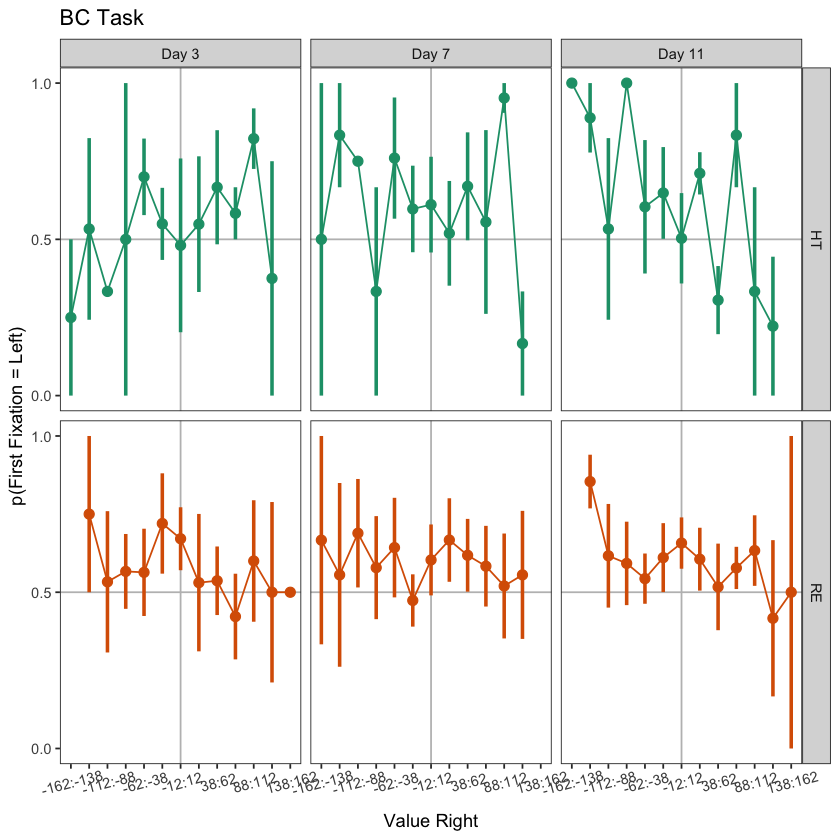

In [7]:
p = data_bc_fix %>%
  filter(firstFix == 1) %>%
  mutate(right_val_bin = round(possiblePayoffright/25),
         right_val_bin_str = paste0(right_val_bin*25-12, ":" , right_val_bin*25+12),
         right_val_bin_str = factor(right_val_bin_str, levels = c("-162:-138", "-137:-113", "-112:-88", "-87:-63", "-62:-38", "-37:-13", "-12:12", "13:37", "38:62", "63:87", "88:112", "113:137", "138:162"))) %>%
  group_by(subnum, day, type, right_val_bin_str) %>%
  summarise(mean_first_fix_left = mean(leftFix),
            num_trials = n(), .groups="keep") %>%
  ungroup() %>%
  group_by(day, type, right_val_bin_str) %>%
  summarise(.groups = 'keep',
            sem_first_fix_left = sd(mean_first_fix_left)/sqrt(n()),
            mean_first_fix_left = mean(mean_first_fix_left),
            num_trials = n()) %>%
  # filter(num_trials>2) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(right_val_bin_str, mean_first_fix_left, color = type))+
   geom_hline(aes(yintercept=.5), color="gray")+
  geom_vline(aes(xintercept = 7), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_first_fix_left - sem_first_fix_left, ymax = mean_first_fix_left + sem_first_fix_left), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Right", y = "p(First Fixation = Left)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_discrete(labels=c("-162:-138", "", "-112:-88", "", "-62:-38", "", "-12:12", "", "38:62", "", "88:112", "", "138:162"))

# ggsave(file=paste0(fig_out_path, 'bc_group_pFirstFixLeftOverRightVal.jpg'), p, height = 5, width=8, units="in")
p

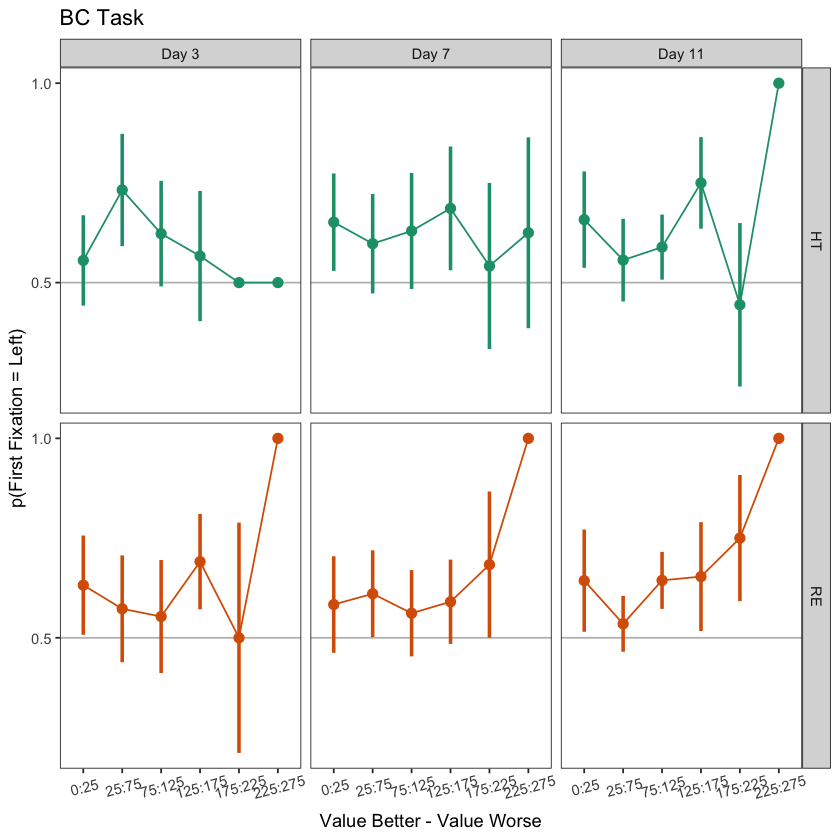

In [8]:
p = data_bc_fix %>%
  filter(firstFix == 1) %>%
  group_by(subnum, day, type, abs_val_diff_bin_str) %>%
  summarise(mean_first_fix_left = mean(leftFix), .groups="keep") %>%
  ungroup() %>%
  group_by(day, type, abs_val_diff_bin_str) %>%
  summarise(.groups = 'keep',
            sem_first_fix_left = sd(mean_first_fix_left)/sqrt(n()),
            mean_first_fix_left = mean(mean_first_fix_left),
            num_trials = n()) %>%
  # filter(num_trials>1) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(abs_val_diff_bin_str, mean_first_fix_left, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_first_fix_left - sem_first_fix_left, ymax = mean_first_fix_left + sem_first_fix_left), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Better - Value Worse", y = "p(First Fixation = Left)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_y_continuous(breaks = seq(0,1,.5))

# ggsave(file=paste0(fig_out_path, 'bc_group_pFirstFixLeftOverValBestDiff.jpg'), p, height = 5, width=8, units="in")
p

## p(First Fix == Best)

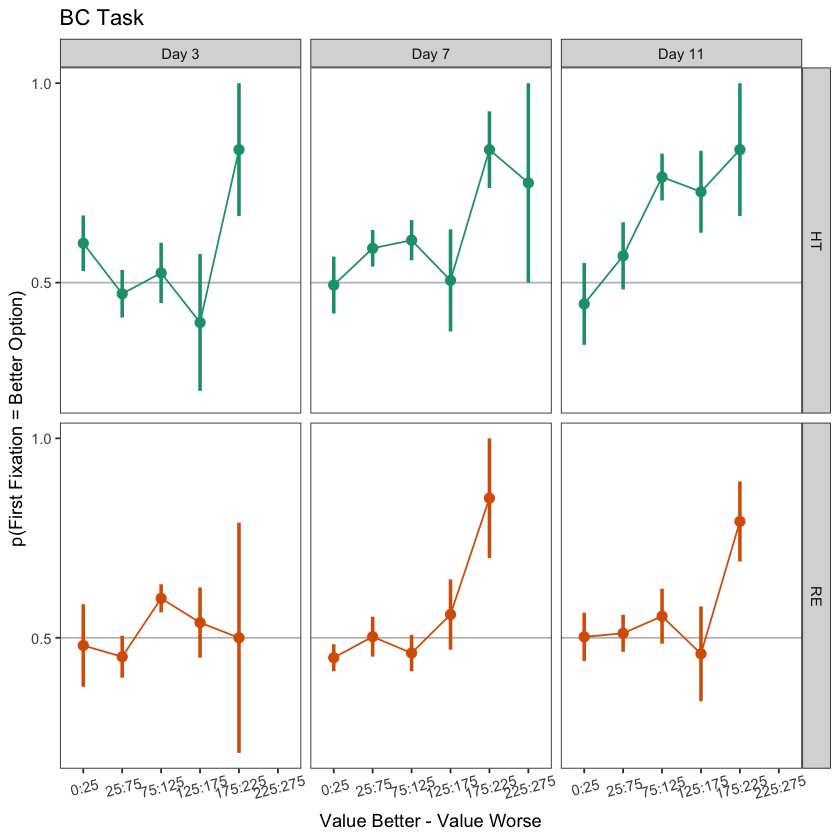

In [9]:
p = data_bc_fix %>%
  filter(firstFix == 1) %>%
  mutate(firstFixToBest = ifelse(leftFix == 1 & val_diff > 0, 1, ifelse(leftFix == 0 & val_diff < 0, 1, 0))) %>%
  group_by(subnum, day, type, abs_val_diff_bin_str) %>%
  summarise(mean_first_fix_best = mean(firstFixToBest), .groups="keep") %>%
  ungroup() %>%
  group_by(day, type, abs_val_diff_bin_str) %>%
  summarise(.groups = 'keep',
            sem_first_fix_best = sd(mean_first_fix_best)/sqrt(n()),
            mean_first_fix_best = mean(mean_first_fix_best),
            num_trials = n()) %>%
  filter(num_trials > 2) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")))%>%
  ggplot(aes(abs_val_diff_bin_str, mean_first_fix_best, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_first_fix_best - sem_first_fix_best, ymax = mean_first_fix_best + sem_first_fix_best), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Better - Value Worse", y = "p(First Fixation = Better Option)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_y_continuous(breaks = seq(0,1,.5))

# ggsave(file=paste0(fig_out_path, 'bc_group_pFirstFixBestOverValBestDiff.jpg'), p, height = 5, width = 8, units="in")
p

## P(Fixation == Best)

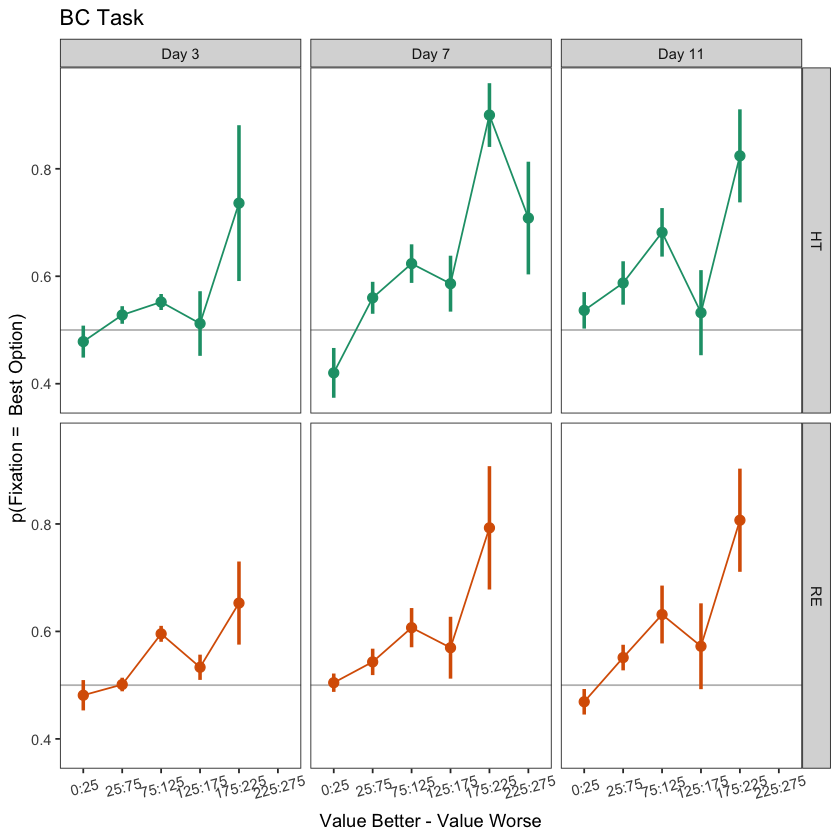

In [10]:
p = data_bc_fix %>%
  mutate(fixOnBest = ifelse( (val_diff > 1 & leftFix == 1), 1, ifelse( (val_diff < 0 & leftFix == 0), 1, 0))) %>%
  group_by(subnum, day, trialNum) %>%
  summarise(.groups = 'keep',
            sumFixOnBest = sum(fixOnBest), 
            totalFix = unique(numTotalFix),
            propFixOnBest = sumFixOnBest/totalFix,
            type = unique(type),
            abs_val_diff_bin_str = unique(abs_val_diff_bin_str)) %>%
  ungroup() %>%
  group_by(subnum, day, abs_val_diff_bin_str, type) %>%
  summarise(.groups = "keep",
            mean_propFixOnBest = mean(propFixOnBest)) %>%
  ungroup() %>%
  group_by(day, abs_val_diff_bin_str, type) %>%
  summarise(.groups = "keep", 
            sem_propFixOnBest = sd(mean_propFixOnBest)/sqrt(n()),
            mean_propFixOnBest = mean(mean_propFixOnBest),
            num_trials = n()) %>%
  filter(num_trials > 2 ) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")))%>%
  ggplot(aes(abs_val_diff_bin_str, mean_propFixOnBest, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_propFixOnBest - sem_propFixOnBest, ymax = mean_propFixOnBest + sem_propFixOnBest), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Better - Value Worse", y = "p(Fixation =  Best Option)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_y_continuous(breaks = seq(.4, 1, .2))

# ggsave(file=paste0(fig_out_path, 'bc_group_propBestFixOverValBestDiff.jpg'), p, height = 5, width = 8, units="in")
p


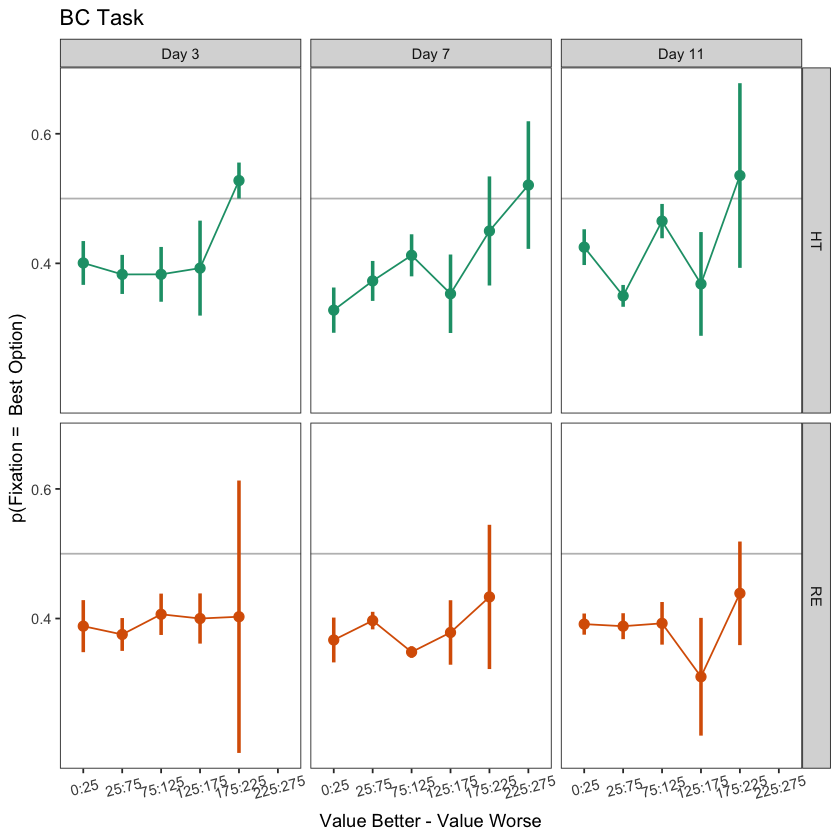

In [11]:
p = data_bc_fix %>%
  filter(lastFix == 0) %>%
  mutate(fixOnBest = ifelse( (val_diff > 1 & leftFix == 1), 1, ifelse( (val_diff < 0 & leftFix == 0), 1, 0))) %>%
  group_by(subnum, day, trialNum) %>%
  summarise(.groups = 'keep',
            sumFixOnBest = sum(fixOnBest), 
            totalFix = unique(numTotalFix),
            propFixOnBest = sumFixOnBest/totalFix,
            type = unique(type),
            abs_val_diff_bin_str = unique(abs_val_diff_bin_str)) %>%
  ungroup() %>%
  group_by(subnum, day, abs_val_diff_bin_str, type) %>%
  summarise(.groups = "keep",
            mean_propFixOnBest = mean(propFixOnBest)) %>%
  ungroup() %>%
  group_by(day, abs_val_diff_bin_str, type) %>%
  summarise(.groups = "keep", 
            sem_propFixOnBest = sd(mean_propFixOnBest)/sqrt(n()),
            mean_propFixOnBest = mean(mean_propFixOnBest),
            num_trials = n()) %>%
  filter(num_trials > 2 ) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")))%>%
  ggplot(aes(abs_val_diff_bin_str, mean_propFixOnBest, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_propFixOnBest - sem_propFixOnBest, ymax = mean_propFixOnBest + sem_propFixOnBest), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Better - Value Worse", y = "p(Fixation =  Best Option)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_y_continuous(breaks = seq(.4, 1, .2))

# ggsave(file=paste0(fig_out_path, 'bc_group_propBestFixOverValBestDiffSansLastFix.jpg'), p, height = 5, width = 8, units="in")
p


## P(Fixation == Chosen)


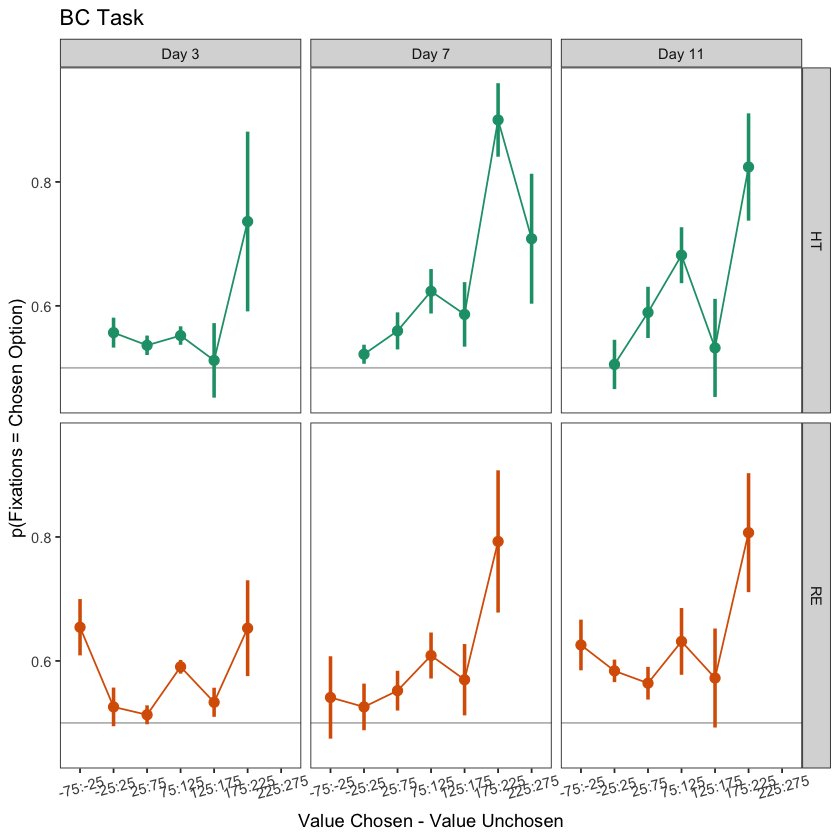

In [12]:
p = data_bc_fix %>%
  mutate(val_chosen_diff = ifelse(leftChosen == 1, possiblePayoffleft - possiblePayoffright, ifelse(leftChosen == 0, possiblePayoffright - possiblePayoffleft, NA)) ,
         val_chosen_diff_bin = round(val_chosen_diff/50),
         val_chosen_diff_bin_str = paste0(val_chosen_diff_bin*50-25,":",val_chosen_diff_bin*50+25),
         val_chosen_diff_bin_str = factor(val_chosen_diff_bin_str, levels = c("-275:-225","-225:-175", "-175:-125", "-125:-75", "-75:-25", "-25:25", "25:75", "75:125", "125:175", "175:225", "225:275")),
         fixOnChosen = ifelse(leftFix == leftChosen, 1, 0)) %>%
  group_by(subnum, day, trialNum) %>%
  summarise(.groups = 'keep',
            sumFixOnChosen = sum(fixOnChosen), 
            totalFix = unique(numTotalFix),
            propFixOnChosen = sumFixOnChosen/totalFix,
            type = unique(type),
            val_chosen_diff_bin_str = unique(val_chosen_diff_bin_str)) %>%
  ungroup() %>%
  group_by(subnum, day, val_chosen_diff_bin_str, type) %>%
  summarise(.groups = "keep",
            mean_propFixOnChosen = mean(propFixOnChosen)) %>%
  ungroup() %>%
  group_by(day, val_chosen_diff_bin_str, type) %>%
  summarise(.groups = "keep", 
            sem_propFixOnChosen = sd(mean_propFixOnChosen)/sqrt(n()),
            mean_propFixOnChosen = mean(mean_propFixOnChosen),
            num_trials = n()) %>%
  filter(num_trials > 2 ) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")))%>%
  ggplot(aes(val_chosen_diff_bin_str, mean_propFixOnChosen, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_propFixOnChosen - sem_propFixOnChosen, ymax = mean_propFixOnChosen + sem_propFixOnChosen), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Chosen - Value Unchosen", y = "p(Fixations = Chosen Option)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none") +
  scale_y_continuous(breaks = seq(.4, 1, .2))

# ggsave(file=paste0(fig_out_path, 'bc_group_propChosenFixOverValChosenDiff.jpg'), p, height = 5, width = 8, units="in")
p

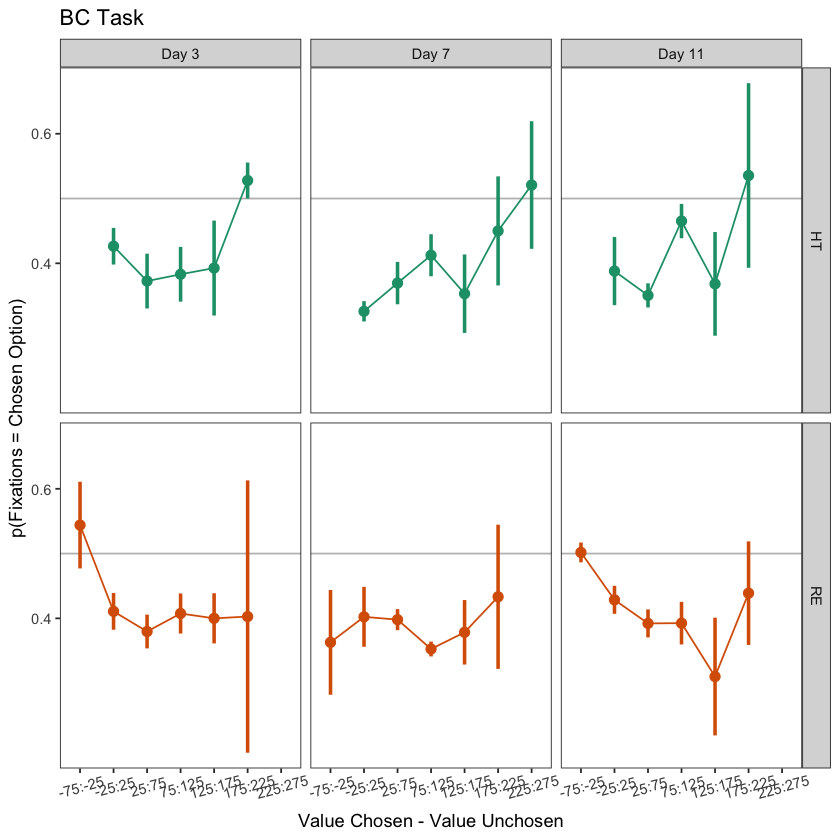

In [13]:
p = data_bc_fix %>%
  mutate(val_chosen_diff = ifelse(leftChosen == 1, possiblePayoffleft - possiblePayoffright, ifelse(leftChosen == 0, possiblePayoffright - possiblePayoffleft, NA)) ,
         val_chosen_diff_bin = round(val_chosen_diff/50),
         val_chosen_diff_bin_str = paste0(val_chosen_diff_bin*50-25,":",val_chosen_diff_bin*50+25),
         val_chosen_diff_bin_str = factor(val_chosen_diff_bin_str, levels = c("-275:-225","-225:-175", "-175:-125", "-125:-75", "-75:-25", "-25:25", "25:75", "75:125", "125:175", "175:225", "225:275")),
         fixOnChosen = ifelse(leftFix == leftChosen, 1, 0)) %>%
  filter(lastFix == 0) %>%
  group_by(subnum, day, trialNum) %>%
  summarise(.groups = 'keep',
            sumFixOnChosen = sum(fixOnChosen), 
            totalFix = unique(numTotalFix),
            propFixOnChosen = sumFixOnChosen/totalFix,
            type = unique(type),
            val_chosen_diff_bin_str = unique(val_chosen_diff_bin_str)) %>%
  ungroup() %>%
  group_by(subnum, day, val_chosen_diff_bin_str, type) %>%
  summarise(.groups = "keep",
            mean_propFixOnChosen = mean(propFixOnChosen)) %>%
  ungroup() %>%
  group_by(day, val_chosen_diff_bin_str, type) %>%
  summarise(.groups = "keep", 
            sem_propFixOnChosen = sd(mean_propFixOnChosen)/sqrt(n()),
            mean_propFixOnChosen = mean(mean_propFixOnChosen),
            num_trials = n()) %>%
  filter(num_trials > 2 ) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")))%>%
  ggplot(aes(val_chosen_diff_bin_str, mean_propFixOnChosen, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_propFixOnChosen - sem_propFixOnChosen, ymax = mean_propFixOnChosen + sem_propFixOnChosen), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", x = "Value Chosen - Value Unchosen", y = "p(Fixations = Chosen Option)", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none") +
  scale_y_continuous(breaks = seq(.4, 1, .2))

# ggsave(file=paste0(fig_out_path, 'bc_group_propChosenFixOverValChosenDiffSansLastFix.jpg'), p, height = 5, width = 8, units="in")
p

# Fixation durations

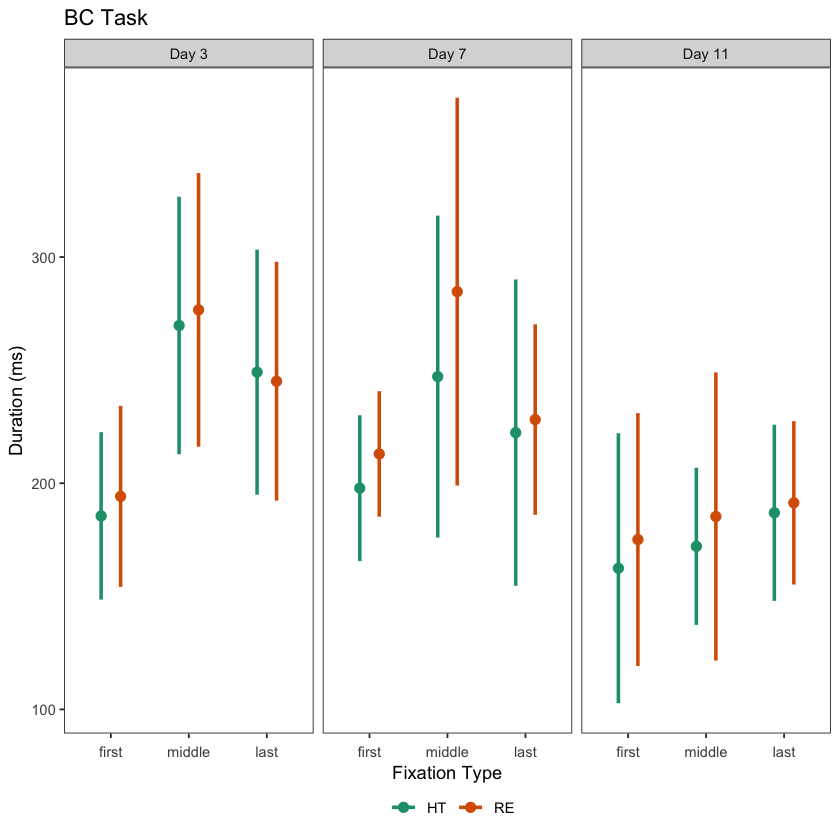

In [14]:
p = data_bc_fix %>%
  select(subnum, day, type, firstFix, middleFix, lastFix, fixDuration) %>%
  mutate(fixType = ifelse(firstFix == 1, "first", ifelse(middleFix == 1, "middle", ifelse(lastFix == 1, "last", NA)))) %>%
  group_by(subnum, day, type, fixType) %>%
  summarise(mean_duration = mean(fixDuration), .groups = "keep") %>%
  ungroup() %>%
  group_by(day, type, fixType) %>%
  summarise(sem_fix_duration = sd(mean_duration),
            mean_fix_duration = mean(mean_duration),
            num_trials = n(),
            .groups = "keep") %>%
  filter(num_trials > 2) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")),
         fixType = factor(fixType, levels = c("first", "middle", "last"))) %>%
  ggplot(aes(fixType, mean_fix_duration, color=type))+
  geom_point(size=2.5, position = position_dodge(width = .5))+
  geom_errorbar(aes(ymax = mean_fix_duration + sem_fix_duration, ymin = mean_fix_duration - sem_fix_duration),size = 1, width = 0, position = position_dodge(width = .5))+
  labs(title = "BC Task", x = "Fixation Type", y = "Duration (ms)", color="")+
  facet_grid(. ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2")

# ggsave(file=paste0(fig_out_path, 'bc_group_fixDurOverFixType.jpg'), p, height = 5, width = 8, units="in")
p  

# Effects of fixation patterns on choice

## p(Choice == Left) ~ first vs. last fixation

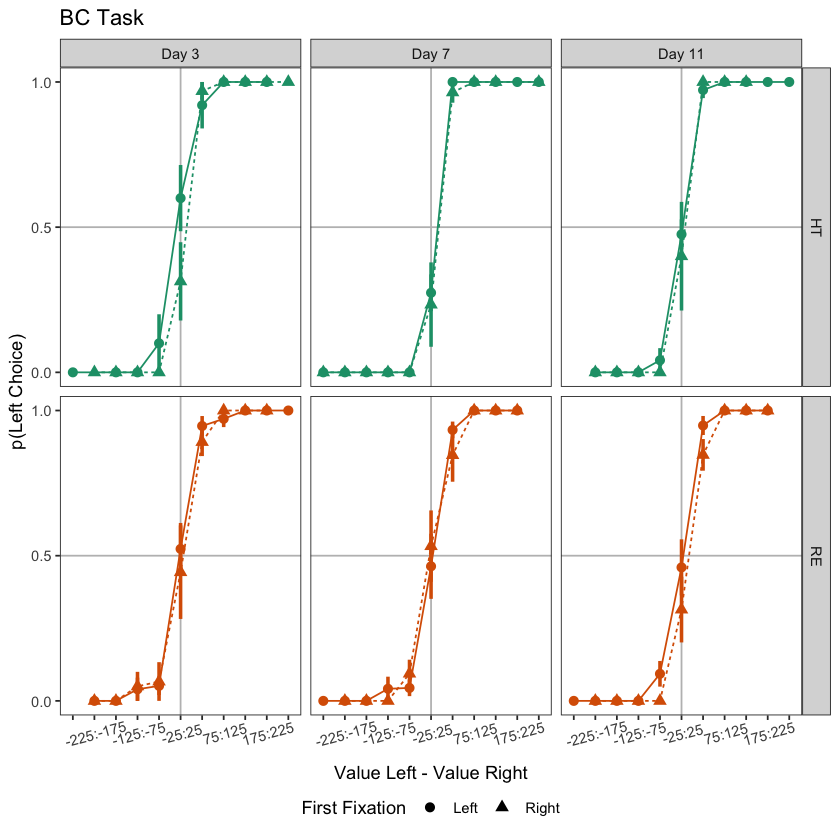

In [15]:
p = data_bc_fix %>%
  filter(!is.na(val_diff_bin_str)) %>%
  filter(firstFix == 1) %>%
  group_by(subnum, day, val_diff_bin_str, leftFix, type) %>%
  summarise(.groups = 'keep',
            mean_left_choice = mean(leftChosen)) %>%
  ungroup() %>%
  mutate(lastFixLeft = ifelse(leftFix == 1, "Left", "Right")) %>%
  select(-leftFix) %>%
  group_by(day, val_diff_bin_str, lastFixLeft, type) %>%
  summarise(.groups = 'keep',
            sem_left_choice = sd(mean_left_choice)/sqrt(n()),
            mean_left_choice = mean(mean_left_choice)) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")),
         sem_left_choice = ifelse(is.na(sem_left_choice), 0, sem_left_choice)) %>%
  ggplot(aes(val_diff_bin_str, mean_left_choice, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_vline(aes(xintercept=6), color="gray")+
  geom_point(aes(shape = lastFixLeft), size=2.5)+
  geom_errorbar(aes(ymin = mean_left_choice - sem_left_choice, ymax = mean_left_choice + sem_left_choice), width = 0, size=1)+
  geom_line(aes(group = lastFixLeft, linetype = lastFixLeft))+
  labs(title = "BC Task", x = "Value Left - Value Right", y = "p(Left Choice)", shape="First Fixation")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_x_discrete(labels=c("","-225:-175", "", "-125:-75", "", "-25:25", "", "75:125", "", "175:225", ""))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_linetype(guide = "none")

# ggsave(file=paste0(fig_out_path, 'bc_group_pLeftOverValDiffByFirstFixByStim.jpg'), p, height = 5, width=8, units="in")
p

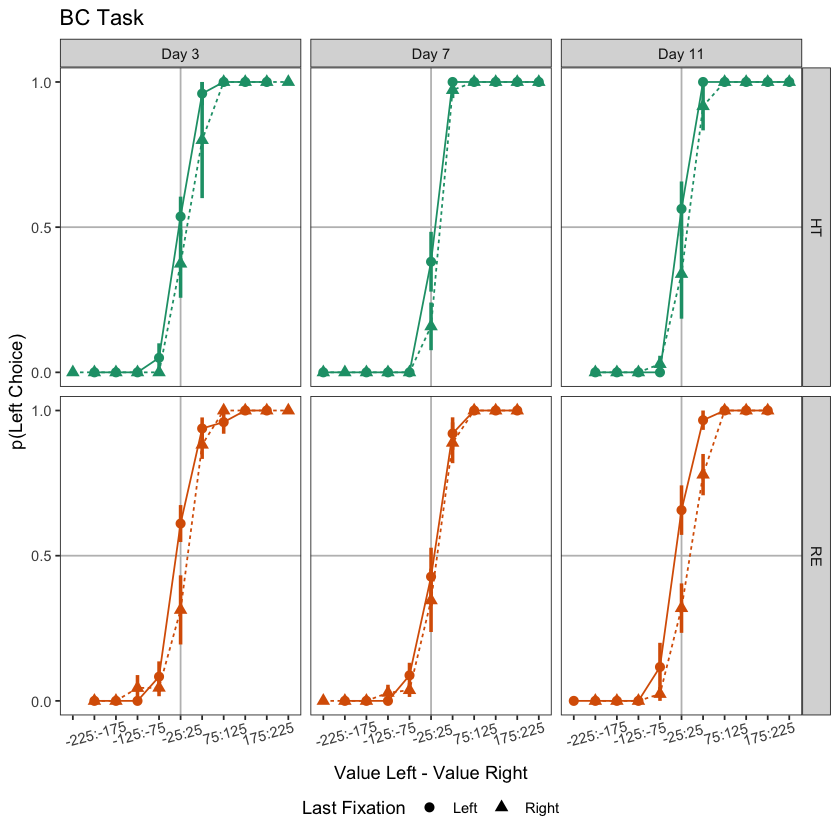

In [16]:
p = data_bc_fix %>%
  filter(!is.na(val_diff_bin_str)) %>%
  filter(lastFix == 1) %>%
  group_by(subnum, day, val_diff_bin_str, leftFix, type) %>%
  summarise(.groups = 'keep',
            mean_left_choice = mean(leftChosen)) %>%
  ungroup() %>%
  mutate(lastFixLeft = ifelse(leftFix == 1, "Left", "Right")) %>%
  select(-leftFix) %>%
  group_by(day, val_diff_bin_str, lastFixLeft, type) %>%
  summarise(.groups = 'keep',
            sem_left_choice = sd(mean_left_choice)/sqrt(n()),
            mean_left_choice = mean(mean_left_choice)) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11")),
         sem_left_choice = ifelse(is.na(sem_left_choice), 0, sem_left_choice)) %>%
  ggplot(aes(val_diff_bin_str, mean_left_choice, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_vline(aes(xintercept=6), color="gray")+
  geom_point(aes(shape = lastFixLeft), size=2.5)+
  geom_errorbar(aes(ymin = mean_left_choice - sem_left_choice, ymax = mean_left_choice + sem_left_choice), width = 0, size=1)+
  geom_line(aes(group = lastFixLeft, linetype = lastFixLeft))+
  labs(title = "BC Task", x = "Value Left - Value Right", y = "p(Left Choice)", shape="Last Fixation")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 15, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_x_discrete(labels=c("","-225:-175", "", "-125:-75", "", "-25:25", "", "75:125", "", "175:225", ""))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_color_brewer(palette = "Dark2", guide = "none")+
  scale_linetype(guide = "none")

# ggsave(file=paste0(fig_out_path, 'bc_group_pLeftOverValDiffByLastFixByStim.jpg'), p, height =5, width=8, units="in")
p

## p(Choice == First fixated)

on first fixation duration

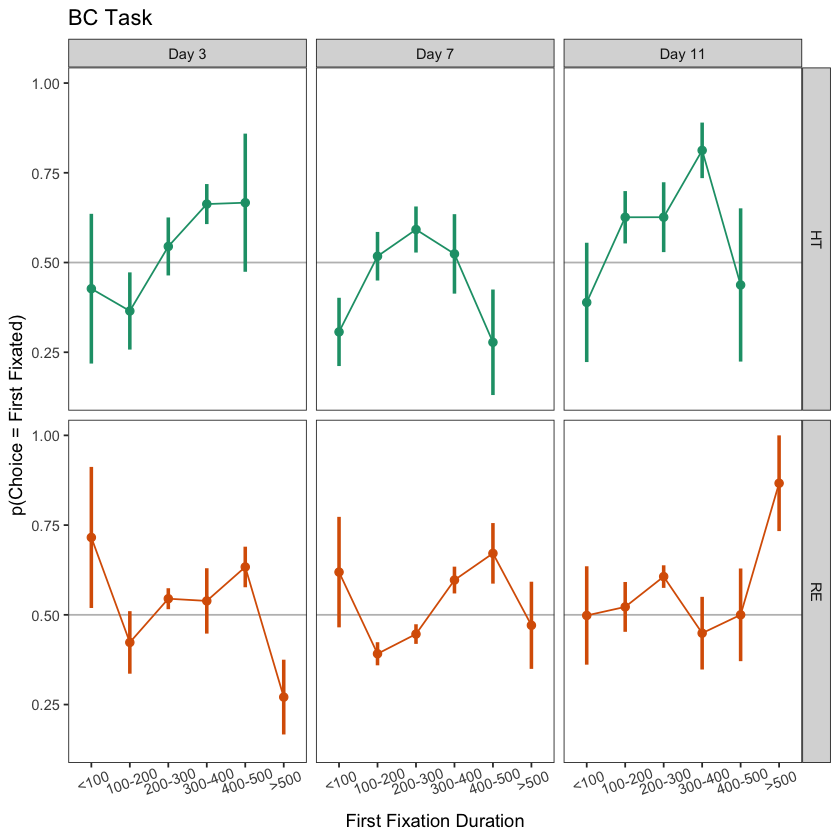

In [17]:
p = data_bc_fix %>%
  filter(firstFix == 1) %>%
  mutate(firstFixChosen = ifelse(leftFix == leftChosen, 1, 0),
         firstFixDurBin = round(fixDuration/100),
         firstFixDurBin = ifelse(firstFixDurBin == 0, "<100",  ifelse(firstFixDurBin == 1, "100-200", ifelse(firstFixDurBin == 2, "200-300", ifelse(firstFixDurBin == 3, "300-400", ifelse(firstFixDurBin == 4, "400-500", ">500"))))),
         firstFixDurBin = factor(firstFixDurBin, levels = c("<100", "100-200", "200-300", "300-400", "400-500", ">500"))) %>%
  group_by(subnum, day, firstFixDurBin, type) %>%
  summarise(.groups = 'keep',
            mean_choice_firstFix = mean(firstFixChosen)) %>%
  ungroup() %>%
  group_by(day, firstFixDurBin, type) %>%
  summarise(sem_choice_firstFix = sd(mean_choice_firstFix)/sqrt(n()),
            mean_choice_firstFix = mean(mean_choice_firstFix), 
            num_trials = n(),.groups = 'keep') %>%
  filter(num_trials > 2) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(firstFixDurBin, mean_choice_firstFix, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2)+
  geom_errorbar(aes(ymin = mean_choice_firstFix - sem_choice_firstFix, ymax = mean_choice_firstFix + sem_choice_firstFix), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", y = "p(Choice = First Fixated)", x = "First Fixation Duration", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 20, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide="none")


# ggsave(file=paste0(fig_out_path, 'bc_group_pFirstFixatedOverFirstFixDurByStim.jpg'), p, height = 5, width=8, units="in")
p

## p(Choice == Last fixated)

on first fixation duration

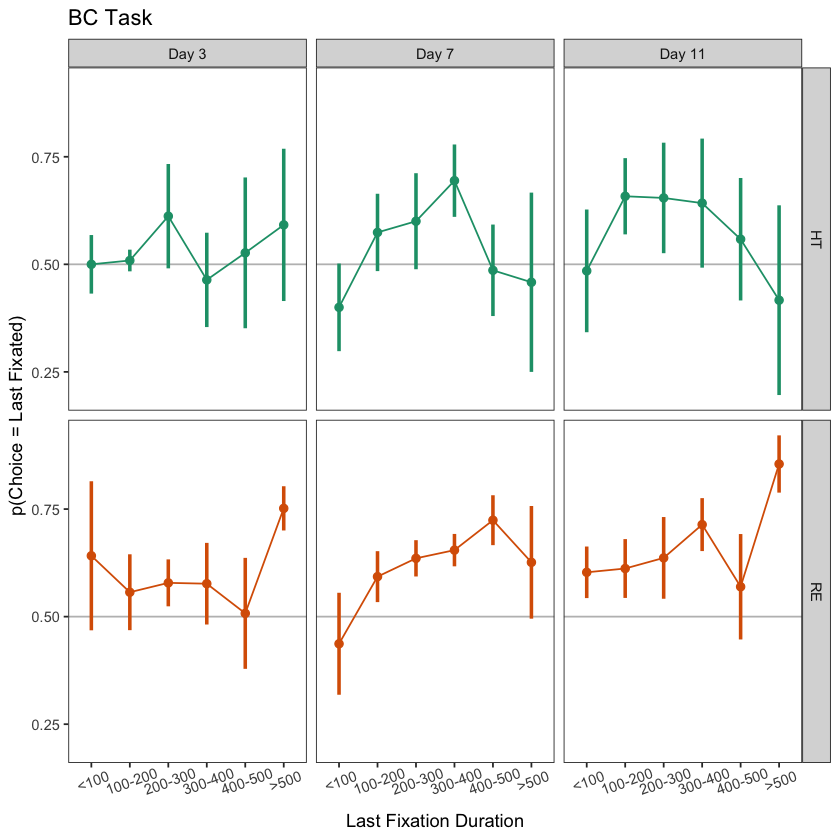

In [18]:
p = data_bc_fix %>%
  filter(lastFix == 1) %>%
  mutate(lastFixChosen = ifelse(leftFix == leftChosen, 1, 0),
         lastFixDurBin = round(fixDuration/100),
         lastFixDurBin = ifelse(lastFixDurBin == 0, "<100",  ifelse(lastFixDurBin == 1, "100-200", ifelse(lastFixDurBin == 2, "200-300", ifelse(lastFixDurBin == 3, "300-400", ifelse(lastFixDurBin == 4, "400-500", ">500"))))),
         lastFixDurBin = factor(lastFixDurBin, levels = c("<100", "100-200", "200-300", "300-400", "400-500", ">500"))) %>%
  group_by(subnum, day, lastFixDurBin, type) %>%
  summarise(.groups = 'keep',
            mean_choice_lastFix = mean(lastFixChosen)) %>%
  ungroup() %>%
  group_by(day, lastFixDurBin, type) %>%
  summarise(sem_choice_lastFix = sd(mean_choice_lastFix)/sqrt(n()),
            mean_choice_lastFix = mean(mean_choice_lastFix), 
            num_trials = n(),.groups = 'keep') %>%
  filter(num_trials > 2) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(lastFixDurBin, mean_choice_lastFix, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2)+
  geom_errorbar(aes(ymin = mean_choice_lastFix - sem_choice_lastFix, ymax = mean_choice_lastFix + sem_choice_lastFix), width = 0, size = 1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", y = "p(Choice = Last Fixated)", x = "Last Fixation Duration", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 20, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide="none")+
  scale_y_continuous(breaks = seq(0,1,.25))


# ggsave(file=paste0(fig_out_path, 'bc_group_pFirstFixatedOverLastFixDurByStim.jpg'), p, height = 5, width=8, units="in")
p

## p(Choice == Side) ~ Side fixation duration

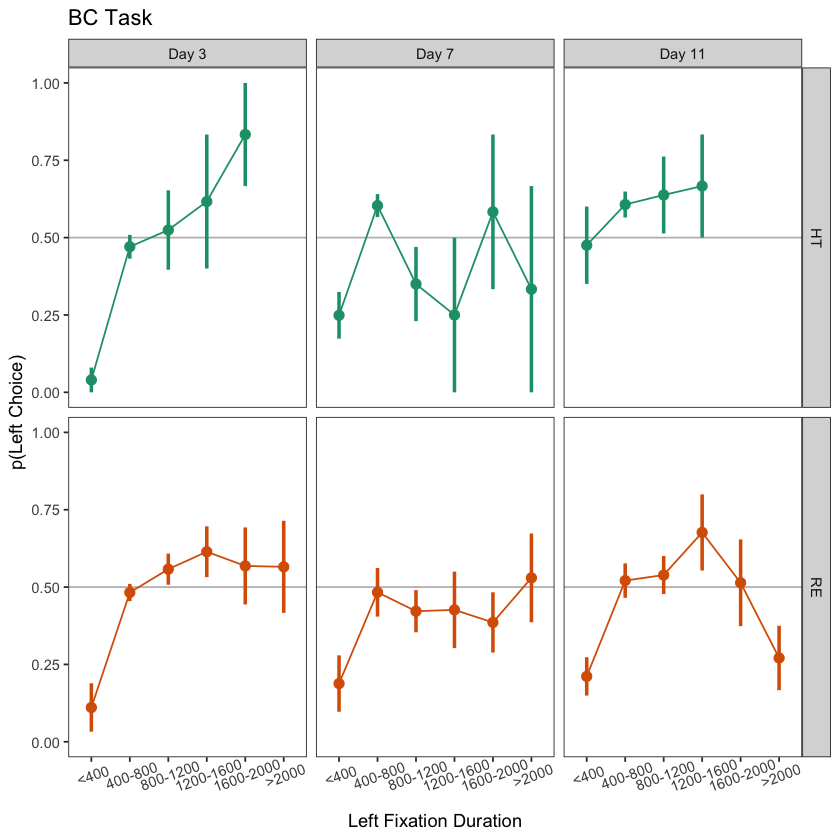

In [19]:
p = data_bc_fix %>%
  filter(abs(val_diff_bin) < 6) %>%
  group_by(subnum, day, type, trialNum, leftFix) %>%
  summarise(.groups = "keep",
            totalFixDuration = sum(fixDuration), 
            leftChosen = unique(leftChosen)) %>%
  mutate(leftFix = ifelse(leftFix == 1, "leftDur", "rightDur")) %>%
  spread(leftFix, totalFixDuration) %>%
  select(-rightDur) %>%
  filter(!is.na(leftDur)) %>%
  mutate(leftDurBin = round(leftDur/400),
         leftDurBin = ifelse(leftDurBin == 0, "<400", ifelse(leftDurBin == 1, "400-800", ifelse(leftDurBin == 2, "800-1200", ifelse(leftDurBin == 3, "1200-1600", ifelse(leftDurBin == 4, "1600-2000", ">2000"))))),
         leftDurBin = factor(leftDurBin, levels = c("<400", "400-800", "800-1200", "1200-1600", "1600-2000", ">2000")))%>%
  ungroup() %>%
  group_by(subnum, day, type, leftDurBin) %>%
  summarise(.groups = 'keep',
            mean_left_choice = mean(leftChosen)) %>%
  ungroup() %>%
  group_by(day, type, leftDurBin) %>%
  summarise(.groups = 'keep',
            sem_left_choice = sd(mean_left_choice)/sqrt(n()),
            mean_left_choice = mean(mean_left_choice),
            num_trials = n()) %>%
  filter(num_trials > 2) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(leftDurBin, mean_left_choice, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_left_choice - sem_left_choice, ymax = mean_left_choice + sem_left_choice), width = 0, size=1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", y = "p(Left Choice)", x = "Left Fixation Duration", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 20, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")

# ggsave(file=paste0(fig_out_path, 'bc_group_pLeftOverNetFixLeftByStim.jpg'), p, height = 5, width=8, units="in")
p

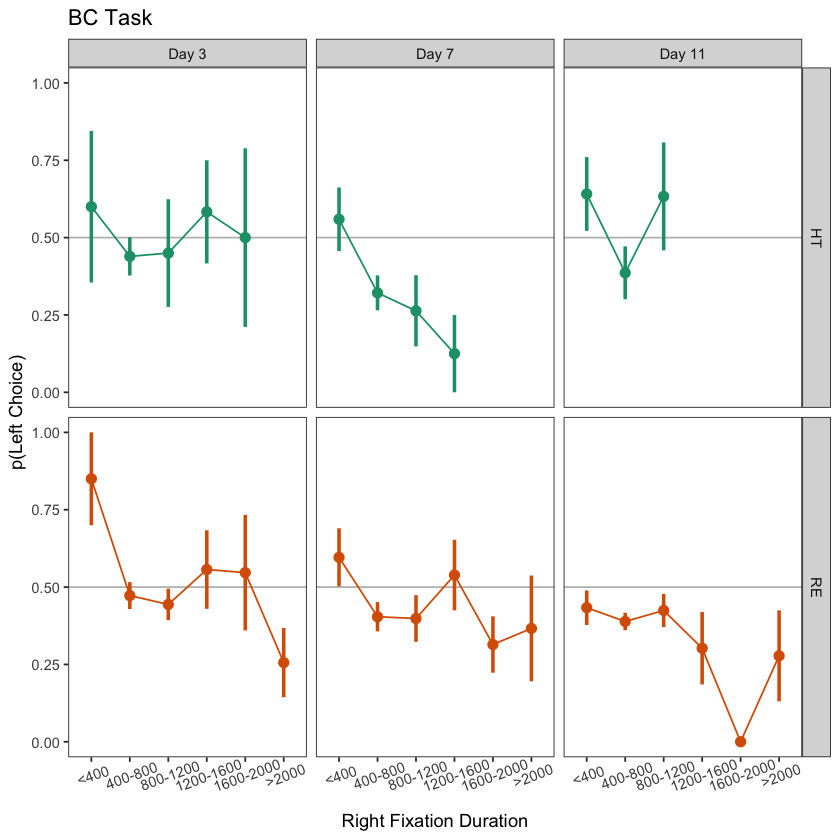

In [20]:
p = data_bc_fix %>%
  filter(abs(val_diff_bin) < 6) %>%
  group_by(subnum, day, type, trialNum, leftFix) %>%
  summarise(.groups = "keep",
            totalFixDuration = sum(fixDuration), 
            leftChosen = unique(leftChosen)) %>%
  mutate(leftFix = ifelse(leftFix == 1, "leftDur", "rightDur")) %>%
  spread(leftFix, totalFixDuration) %>%
  select(-leftDur) %>%
  filter(!is.na(rightDur)) %>%
  mutate(rightDurBin = round(rightDur/400),
         rightDurBin = ifelse(rightDurBin == 0, "<400", ifelse(rightDurBin == 1, "400-800", ifelse(rightDurBin == 2, "800-1200", ifelse(rightDurBin == 3, "1200-1600", ifelse(rightDurBin == 4, "1600-2000", ">2000"))))),
         rightDurBin = factor(rightDurBin, levels = c("<400", "400-800", "800-1200", "1200-1600", "1600-2000", ">2000")))%>%
  ungroup() %>%
  group_by(subnum, day, type, rightDurBin) %>%
  summarise(.groups = 'keep',
            mean_left_choice = mean(leftChosen)) %>%
  ungroup() %>%
  group_by(day, type, rightDurBin) %>%
  summarise(.groups = 'keep',
            sem_left_choice = sd(mean_left_choice)/sqrt(n()),
            mean_left_choice = mean(mean_left_choice),
            num_trials = n()) %>%
  filter(num_trials > 2) %>%
  mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 3", "Day 7", "Day 11"))) %>%
  ggplot(aes(rightDurBin, mean_left_choice, color = type))+
  geom_hline(aes(yintercept=.5), color="gray")+
  geom_point(size = 2.5)+
  geom_errorbar(aes(ymin = mean_left_choice - sem_left_choice, ymax = mean_left_choice + sem_left_choice), width = 0, size=  1)+
  geom_line(aes(group = type))+
  labs(title = "BC Task", y = "p(Left Choice)", x = "Right Fixation Duration", color="")+
  facet_grid(type ~ day)+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 20, margin = margin(t = 5)),
        legend.box.margin=margin(t = -10))+
  scale_color_brewer(palette = "Dark2", guide = "none")

# ggsave(file=paste0(fig_out_path, 'bc_group_pLeftOverNetFixRightByStim.jpg'), p, height = 5, width=8, units="in")
p